# Ban Luck - Using Reinforcement Learning to Squeeze your Relatives Dry

## What is Ban Luck?
In Southeast Asia (SEA), a Chinese New Year (CNY) tradition is to play Chinese Blackjack (Ban Luck) as a social activity. 

The game is as follows:

![How to Play?](assets/how_to_play.png "How to Play?")

**But you don't want to leave it down to luck, you want to "huat" (Be prosperous), so how do you squeeze every penny out of your relatives?**

## A typical strategy

### The Algorithm
As a player, when it is my turn, I follow the following algorithm:
```
Loop until Hold or Reveal:
  Let value = Hand value
  if value == 21 or value >= 17:
    Hold
  else:
    Draw
  if hand has 5 cards:
    Reveal
```

As a dealer, I would follow a similar algorithm but instead of holding, I would reveal hands.

Feels simple, and based on vibes, it seems sound!

### Benchmarking
But let's simulate some games with this algorithm and see how well it actually performs. 

For simplicity, 
- Let's assume everyone uses this algorithm.
- For all our runs unless otherwise stated, we will stick to 8 players (Including dealer).

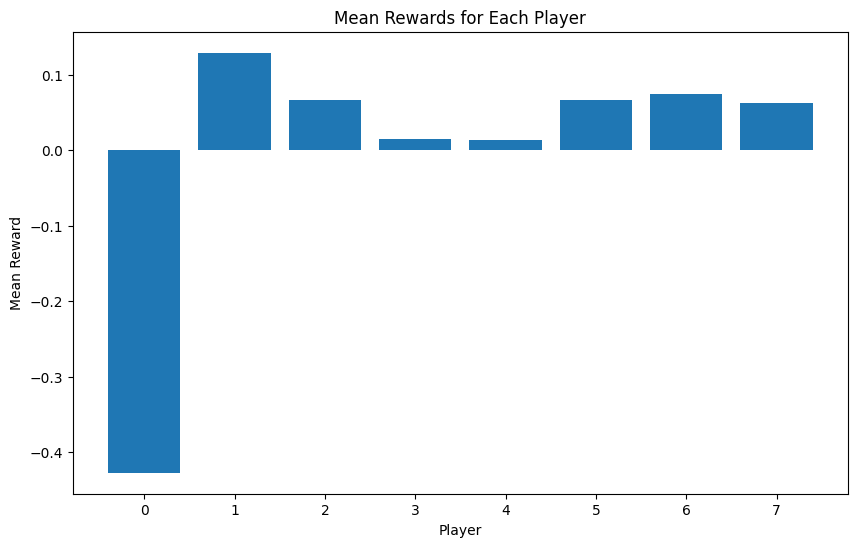

In [ ]:
from players import SimplePlayer
from dealer import SimpleDealer
from game import Game, make_deck
from simulation import run_game
import numpy as np
import matplotlib.pyplot as plt
from deck import SwooshShuffleStrategy

N_PLAYERS = 8 # Includes dealer
SIMULATIONS = 1_000
# Exclude dealer
game = Game(n_players=N_PLAYERS - 1)

# rewards[i, j] is the reward for the j-th player in the i-th simulation
rewards = np.zeros((SIMULATIONS, N_PLAYERS))

deck = make_deck()
shuffle = SwooshShuffleStrategy()
for i in range(SIMULATIONS):
    shuffle.shuffle(deck) # Random shuffle
    # Simple is the strategy name for the algorithm we just described
    res = run_game(game, SimplePlayer(), SimpleDealer(), deck=deck)
    for j in range(N_PLAYERS):
        rewards[i, j] = res[j]
    game.soft_reset()

# Calculate the mean reward for each player
mean_rewards = np.mean(rewards, axis=0)
mean_rewards

# Plot the mean rewards for each player
plt.figure(figsize=(10, 6))
plt.bar(range(N_PLAYERS), mean_rewards)
plt.xlabel('Player')
plt.ylabel('Mean Reward')
plt.title('Mean Rewards for Each Player')
plt.show()
